## Initialization

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import os
from PIL import Image

import torch
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import VGG16_Weights

data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids['panoid'],
    'longitude': panoids['lng'],
    'latitude': panoids['lat'],
}
images_df = pd.DataFrame(image_data)


In [44]:
# Create GeoDataFrame for Images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=network.crs)

In [45]:
# Perform Spatial Join to find nearest street for each image 
matched = gpd.sjoin_nearest(images_gdf, network, how='left', distance_col='distance')

print(matched[['panoid', 'longitude', 'latitude', 'distance']].head())  #Dist in km

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


                   panoid  longitude   latitude  distance
0  wFmLm4GhS7AYVonj6tRIJw  -0.107827  51.510414  0.000473
1  ITjfv5l9KG5ImWa7eTOzAw  -0.107077  51.510418  0.000465
2  WeKFQgVRtO_lzp_4gT1HQw  -0.108574  51.510413  0.000482
3  Lm1UtkHFMqfCPgewzinz6Q  -0.108627  51.510975  0.000020
4  AU89QzVV0jU915gldn3wrQ  -0.108001  51.510957  0.000004


## Image ID to coords & Visualization

In [46]:
# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched[matched['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None 

#Example: Image ID 12 returns lat, long
get_coords_by_image_id(12)

(-0.1092318732591195, 51.5109870682374)

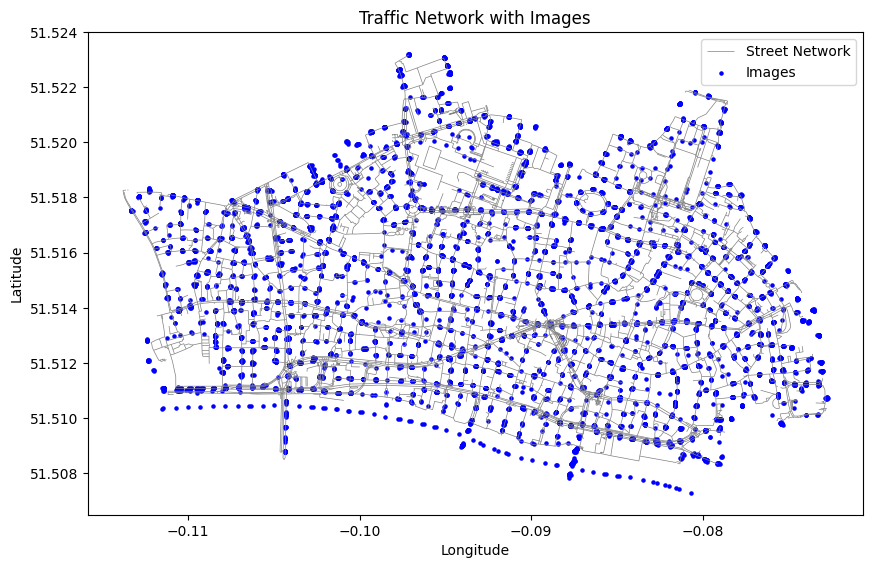

In [47]:
# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
network.plot(ax=ax, color='gray', linewidth=0.5, label='Street Network')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()

plt.show()

## Images to vector embeddings

In [75]:
# Load the pre-trained VGG16 model from the IMAGENET online database to use for training
vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
vgg.classifier[6] = torch.nn.Identity()  # Last layer turned into I-matrix such that the embeddings will not be trained on 1000 classes from the ImageNet database

In [77]:
# Function to load an image and transform it
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to get embeddings from the modified VGG16 model
def get_embeddings(model, image_path):
    image = load_image(image_path)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        embeddings = model(image)
    return embeddings

In [80]:
imagedb_path = Path(r"D:\School2(M)\DSAIE\STREET\London_UK\imagedb") #CHANGE THIS TO YOUR LOCATION
image_files = [f for f in imagedb_path.glob('*.png')]

np.random.seed(42)  
selected_images = np.random.choice(image_files, 20) #THIS TAKES N IMAGES FROM THE FOLDER AS SAMPLE

# Get embeddings for each selected image
for image_path in selected_images:
    vgg_embeddings = get_embeddings(vgg, image_path)
    print(f"Image: {image_path}")
    print("VGG Embeddings Shape:", vgg_embeddings.shape)
    print(vgg_embeddings)
    print()

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_1_s_a.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_4_s_b.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.2124]])

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_3_s_a.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0.4147, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_2_s_a.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_1_s_b.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1352, 0.0000]])

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_5_b.png
VGG Embeddings Shape: torch.Size([1, 4096])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Image:

## Clustering by K-means 

In [85]:
from sklearn.cluster import KMeans

# Extract embeddings for each selected image
embeddings_list = []
for image_path in selected_images:
    vgg_embeddings = get_embeddings(vgg, image_path)
    embeddings_list.append(vgg_embeddings.squeeze().numpy())  # Remove batch dimension and convert to numpy array

# Convert embeddings list to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-Means clustering
num_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings_array)

# Print cluster assignments for each image
for image_path, cluster in zip(selected_images, kmeans.labels_):
    print(f"Image: {image_path} -> Cluster: {cluster}")

Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_1_s_a.png -> Cluster: 4
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_4_s_b.png -> Cluster: 0
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_3_s_a.png -> Cluster: 0
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_2_s_a.png -> Cluster: 2
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_1_s_b.png -> Cluster: 3
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_5_b.png -> Cluster: 1
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_1_s_a.png -> Cluster: 4
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_4_s_a.png -> Cluster: 0
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_5_s_a.png -> Cluster: 0
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_2_s_a.png -> Cluster: 2
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_2_s_a.png -> Cluster: 2
Image: D:\School2(M)\DSAIE\STREET\London_UK\imagedb\image_5_s_b.png -> Cluster: 0
Image: D:\School2(

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


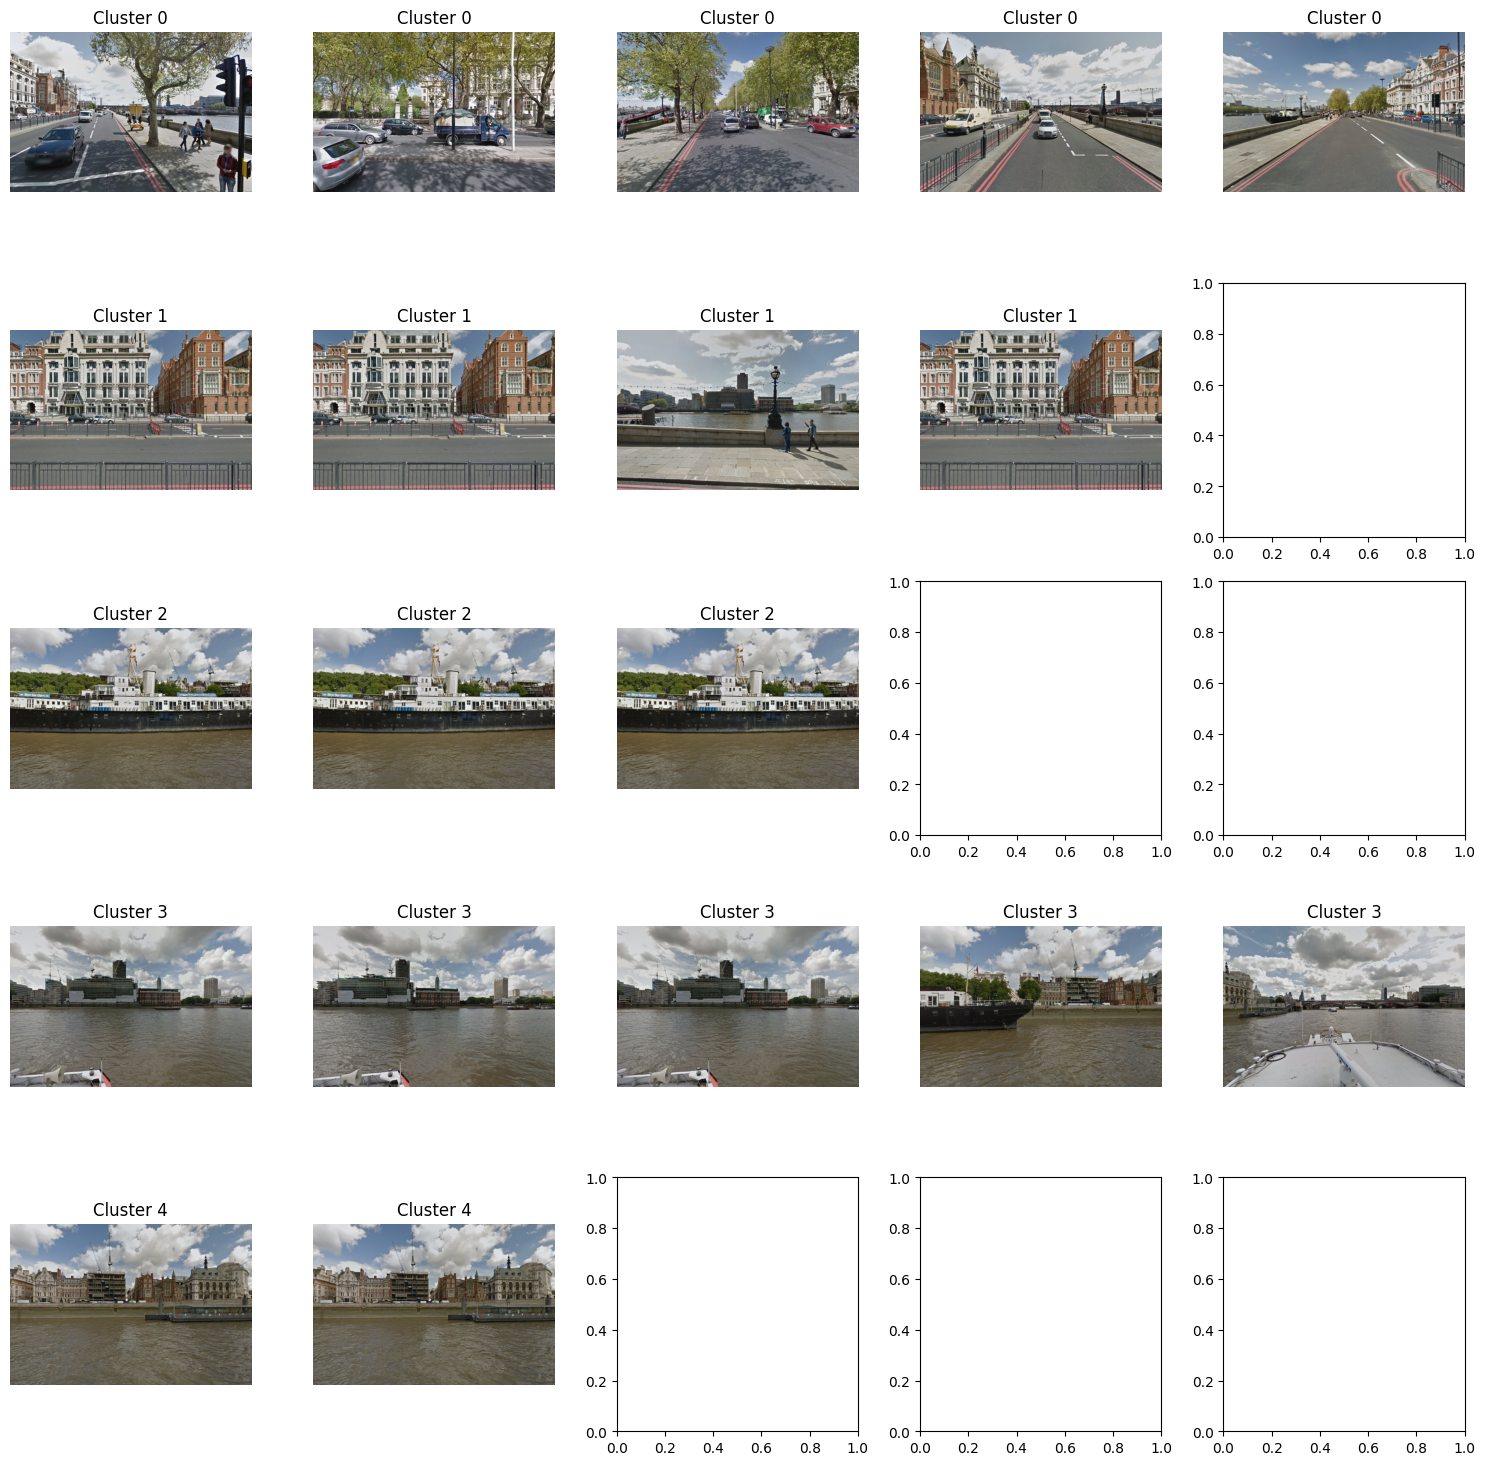

In [86]:
# Function to plot images from each cluster
def plot_clusters(selected_images, labels, num_clusters):
    fig, axes = plt.subplots(num_clusters, 5, figsize=(15, num_clusters * 3))
    for cluster in range(num_clusters):
        cluster_images = [img for img, label in zip(selected_images, labels) if label == cluster]
        for i, image_path in enumerate(cluster_images[:5]):  # Show up to 5 images per cluster
            image = Image.open(image_path)
            ax = axes[cluster, i]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Cluster {cluster}")
    plt.tight_layout()
    plt.show()

# Plot images from each cluster
plot_clusters(selected_images, kmeans.labels_, num_clusters)